# Two Stream Generation 
### Backgroun + Foreground
#### Reference: MIT Generating Video with Scene Dynamics[http://web.mit.edu/vondrick/tinyvideo/]

In [1]:
from util import *
from util.parser import *
from util.img_kit import *
from util.tf_ops import *
from util.notebook_display import *
from util.numeric_ops import *
from IPython import display
import numpy as np
from scipy import ndimage
from scipy import misc
from os import walk
import os
import tensorflow as tf
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['figure.figsize'] = (5.0, 5.0) # set default size of plots
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

In [2]:
img_collections = get_processed_moving_box()
# number of images for each collection
num_per_collection = [x.shape[0] for x in img_collections]
# number of collections
n_collection = len(img_collections)
# total number of images
total_imgs = sum(num_per_collection)
print("\nAfter Augmentation: img_collections has {} collections, {} images in total".format(n_collection, total_imgs))

{'images:': 'triangle', 'dim': (50, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'trangle-vertical', 'dim': (56, 32, 32)}
{'images:': 'circle-diagnal', 'dim': (56, 32, 32)}
{'images:': 'square-diagnal-2', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-2', 'dim': (56, 32, 32)}
{'images:': 'trangle-vertical-3', 'dim': (56, 32, 32)}
{'images:': 'trangle-horizontal', 'dim': (56, 32, 32)}
{'images:': 'square-vertical-3', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'trangle-vertical-2', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'moving box uniform', 'dim': (14, 32, 32)}
{'images:': 'circle', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'rectangle', 'dim': (56, 32, 32)}
{'images:': 'circle-diagnal-2', 'dim': (56, 32, 32)}
{'images:': 'square-vertical', 'dim': (56, 32, 32)}


In [3]:
train_ind_collection, val_ind_collection = zip(*[split_train_dev(x) for x in img_collections])

In [4]:
def sample(batch_size = 8, train=True, gap = 1):
    # get average number of training for each class
    avg_num_per_class = int(np.ceil(batch_size/n_collection))
    # before-index for each class
    before_ind = []
    for i in range(n_collection):
        data = train_ind_collection[i] if train else val_ind_collection[i]
        try:
            s = np.random.choice(list(filter(lambda x:x<num_per_collection[i]-gap-1, data)),avg_num_per_class, replace=False)
            before_ind.append(s)
        except:
            before_ind.append(np.array([]))
    # after-index for each class
    after_ind = [x+gap+1 for x in before_ind]
    # mid-index for each class
    mid_ind = [x+(gap+1)//2 for x in before_ind]
    
    selected_classed = [i for i in range(n_collection) if before_ind[i].shape[0]>0]
    before_imgs = np.concatenate([img_collections[i][before_ind[i]] for i in selected_classed], axis = 0)
    after_imgs = np.concatenate([img_collections[i][after_ind[i]] for i in selected_classed], axis = 0)
    mid_imgs = np.concatenate([img_collections[i][mid_ind[i]] for i in selected_classed], axis = 0)
    
    clipped = np.random.choice(range(before_imgs.shape[0]), batch_size, replace=False)
    before_imgs = before_imgs[clipped]
    mid_imgs = mid_imgs[clipped]
    after_imgs = after_imgs[clipped]
    return (before_imgs, after_imgs), mid_imgs

In [5]:
def sample_train(batch_size = 8, gap = 1):
    return sample(batch_size)
def sample_dev(batch_size = 8, gap = 1):
    return sample(batch_size, False, gap)

## Take a look at input data

Before: (4, 32, 32)
After:  (4, 32, 32)
Mid:    (4, 32, 32)


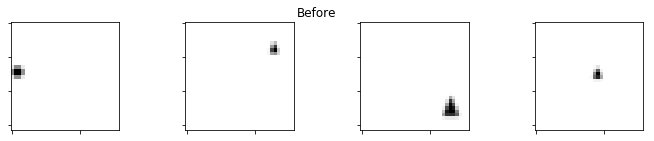

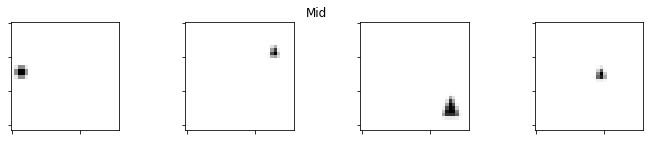

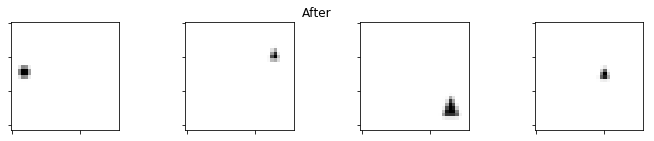

In [54]:
(test_before, test_after), test_mid = sample_train(4)
print("Before: {}".format(test_before.shape))
print("After:  {}".format(test_after.shape))
print("Mid:    {}".format(test_mid.shape))
size = (12, 2)
plot_images(test_before, size, "Before")
plot_images(test_mid, size, "Mid")
plot_images(test_after, size, "After")

In [55]:
def content_loss(x, gd):
    x, gd = tf.contrib.layers.flatten(x), tf.contrib.layers.flatten(gd)
    return tf.norm(x-gd)

## Extract Background

In [56]:
def extract_background(x, is_training=True):
    x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)
    
    x = tf.contrib.layers.flatten(x)
    x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, training=is_training)
    
    x = tf.reshape(x, [-1, 32, 32, 1])
    x = tf.layers.conv2d(x, filters = 32, kernel_size=2, strides=1, padding='same', activation=tf.nn.relu)
    x = tf.layers.batch_normalization(x, axis=3, training=is_training)
    x = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4), activation=tf.nn.tanh, padding='same')
    return x

## Generator

In [69]:
def generate(x1, x2,  is_training=True):
    """
    Input:
        x1, x2: batch size of images for inference
    Output:
        predicted images of batch size
    """
    with tf.variable_scope("generator") as scope:
        # reshape and concatenate
        x1 = tf.reshape(x1, [-1,  32, 32, 1])
        x2 = tf.reshape(x2, [-1,  32, 32, 1])
        x = tf.concat([(x1+x2)/2, (x2-x1)], axis=3)
        
        background= extract_background(x, is_training)
        
        x = tf.layers.conv2d(x, filters = 128, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d(x, filters = 64, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.contrib.layers.flatten(x)
        x = tf.layers.dense(x, 1024, activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, training=is_training)
        
        x = tf.layers.dense(x, 8*8*128, activation=tf.nn.relu)
        x = tf.reshape(x, [-1, 8, 8, 128])
        
        x = tf.layers.conv2d(x, filters = 32, kernel_size=2, padding='same', activation=tf.nn.relu)
        x = tf.layers.batch_normalization(x, axis=3, training=is_training)
        
        x = tf.layers.conv2d_transpose(x, filters=64, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.relu, padding='same')
        x = tf.layers.batch_normalization(x,  axis=3, training=is_training)
        
        ####### split into Mask and Foreground  ####### 
        # Foreground - relu activation
        fg = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4),  strides=(2, 2), activation=tf.nn.tanh, padding='same')
        fg = tf.reshape(fg, [-1, 32, 32, 1])
        # Mask
        mask = tf.layers.conv2d_transpose(x, filters=1, kernel_size=(4, 4), strides=(2, 2), activation=tf.nn.sigmoid, padding='same')
        mask = tf.reshape(mask, [-1, 32, 32, 1])
        
        # Assemble background, foreground, and mask into final image
        img = mask * fg + (1-mask) * background
        return img, background, fg

In [70]:
def get_generattion(before, after, mid):
    dic = {batch_before: before, batch_after: after, batch_mid: mid, is_training: False}
    gen_batch = sess.run(G_batch, dic)
    gen_batch, loss = sess.run([G_batch, G_loss], dic)
    return gen_batch, loss

### Model Param

In [71]:
gap = 1
batch_size = 16

learning_rate = 1e-4
beta = 0.9
num_iteration = 4000
relu_alpha = 0.01

In [72]:
tf.reset_default_graph()
batch_mid        = tf.placeholder(tf.float32, [None, 32, 32])
batch_before     = tf.placeholder(tf.float32, [None, 32, 32])
batch_after      = tf.placeholder(tf.float32, [None, 32, 32])
is_training      = tf.placeholder(tf.bool, ())

G_batch, Background, Foreground = generate(batch_before, batch_after)

G_loss = content_loss(G_batch, batch_mid)
_, G_solver = get_solvers_adam(learning_rate, beta)

G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

G_train_step = G_solver.minimize(G_loss, var_list=G_vars)

In [73]:
def train(sess, G_step, G_loss, batch_size, num_iteration, plot_every = 400, show_loss_every=400, nPlot=6):
    g_losses = []
    for i in range(num_iteration):
        (real_before, real_after), real_mid = sample_train(batch_size, gap)
        dic = {batch_mid: real_mid, batch_before: real_before, batch_after: real_after, is_training: True}
        sess.run([G_train_step], dic)
        G_loss_curr = sess.run(G_loss, dic)
        g_losses.append(G_loss_curr)
        if i%show_loss_every ==0:
            print("Iteration {}:  G_loss = {}".format(i, G_loss_curr))
            
        if i%plot_every == 0:
            gen_batch_test, background_batch, foreground_batch = sess.run([G_batch, Background, Foreground], feed_dict=\
                                      {batch_before: real_before, batch_after: real_after, is_training: False})
            plot_batch_images(gen_batch_test[:nPlot], (16, 2) , "Iteration: {}".format(i))
            plot_batch_images(background_batch[:nPlot], (16, 2) , "Iteration: {} | background".format(i))
            plot_batch_images(foreground_batch[:nPlot], (16, 2) , "Iteration: {} | foreground".format(i))
    return g_losses

## Train !

Iteration 0:  G_loss = 133.92152404785156


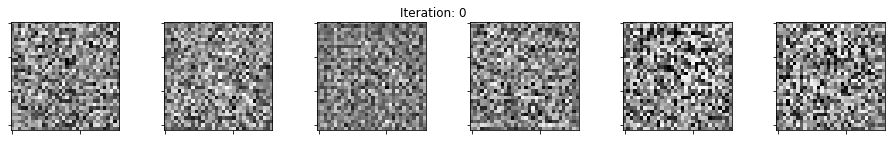

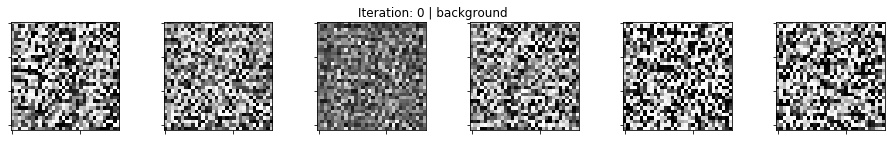

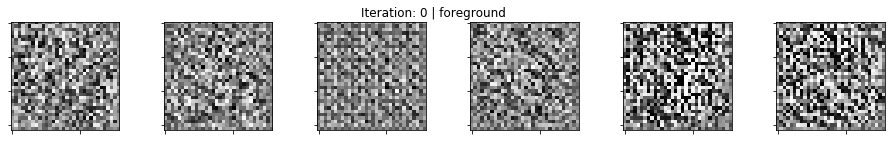

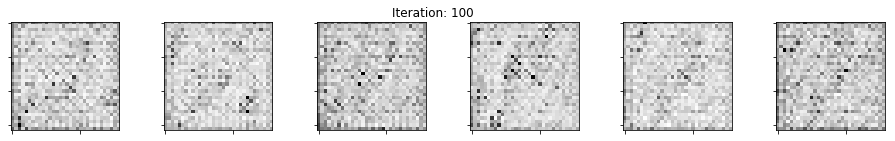

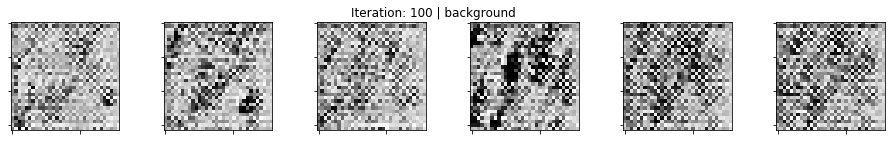

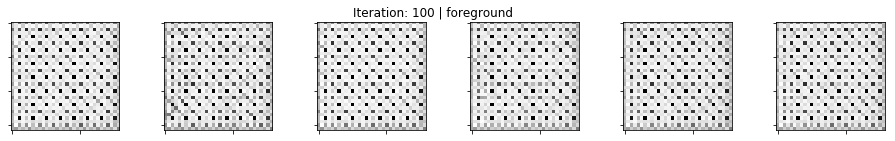

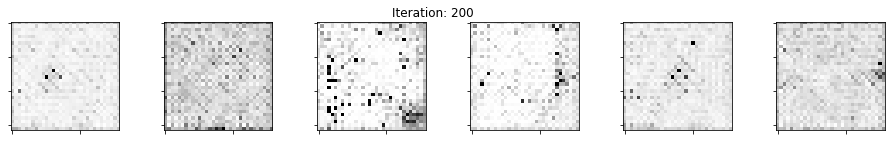

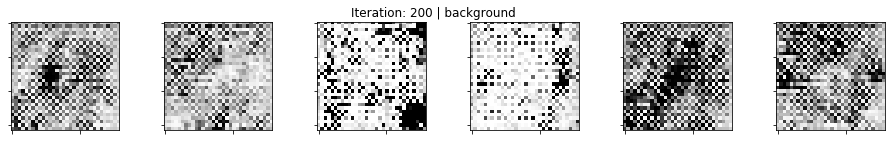

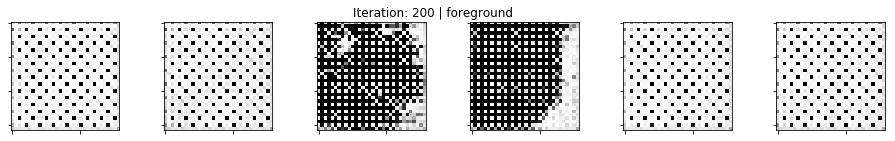

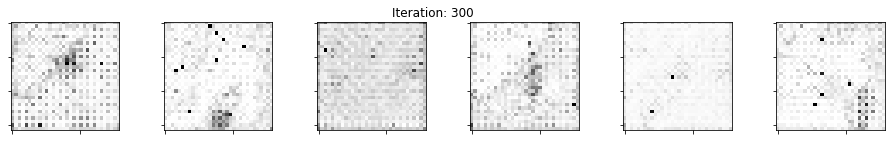

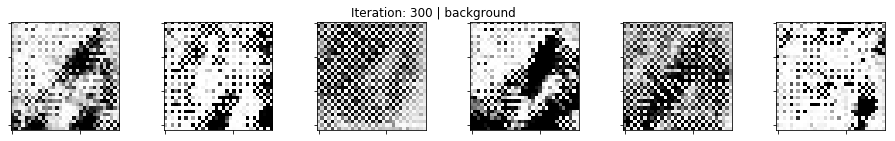

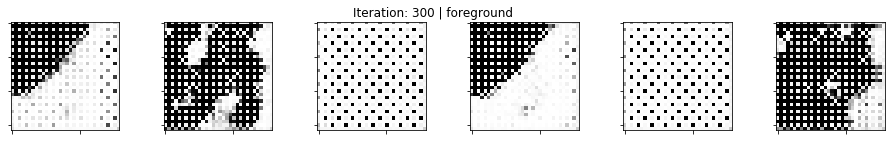

Iteration 400:  G_loss = 14.266326904296875


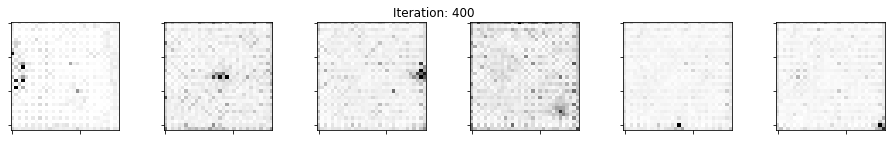

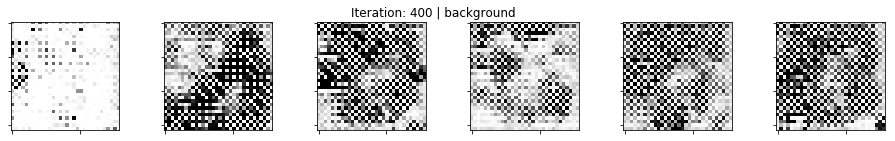

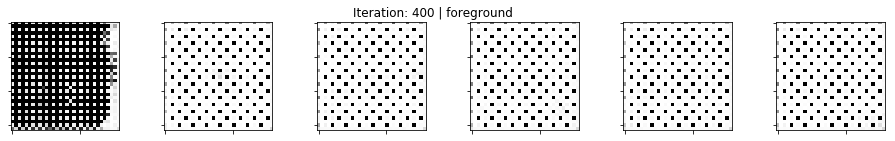

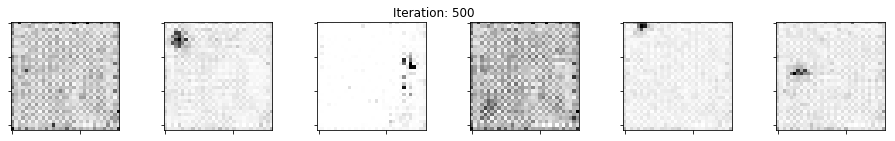

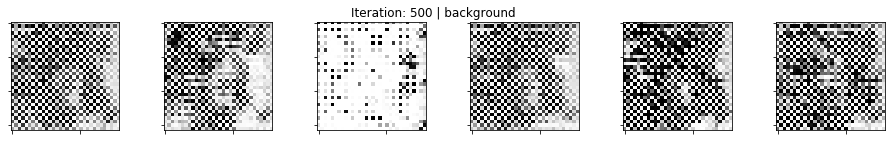

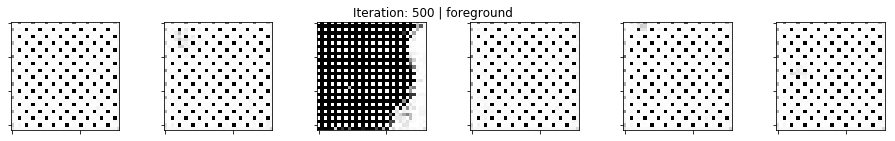

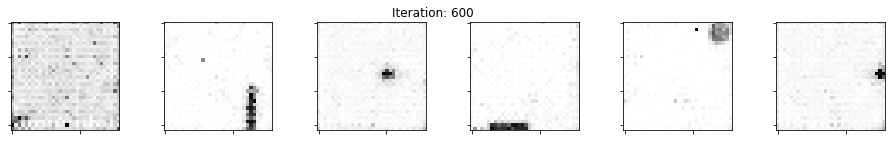

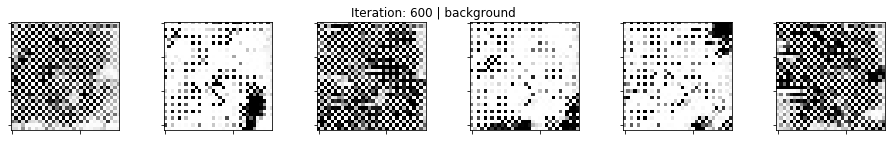

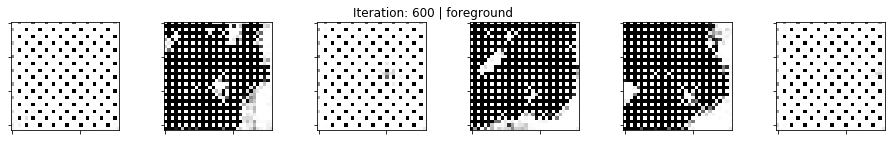

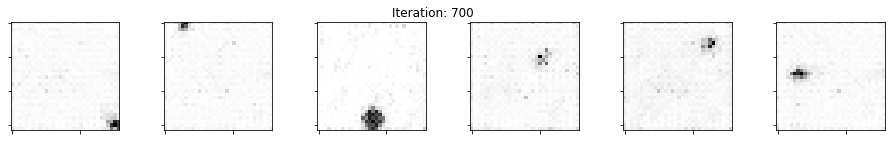

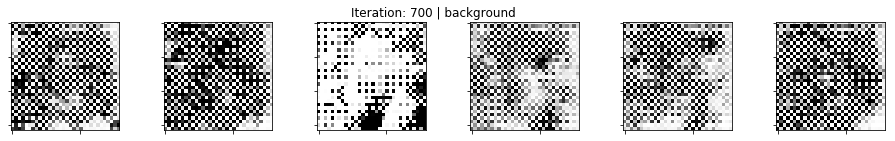

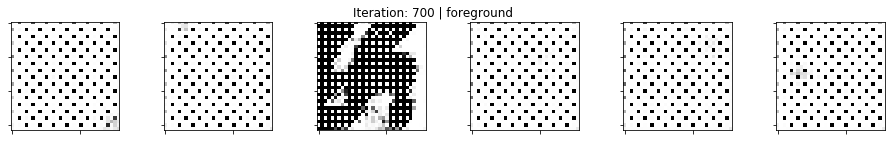

Iteration 800:  G_loss = 7.3976335525512695


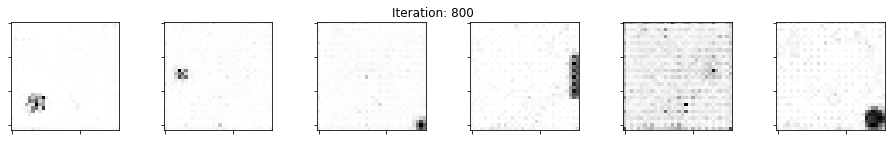

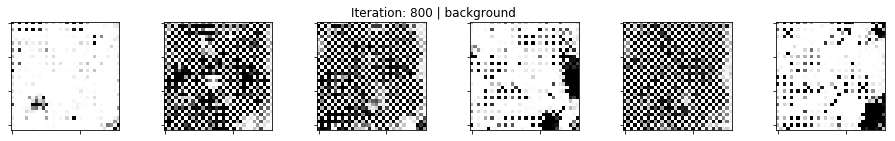

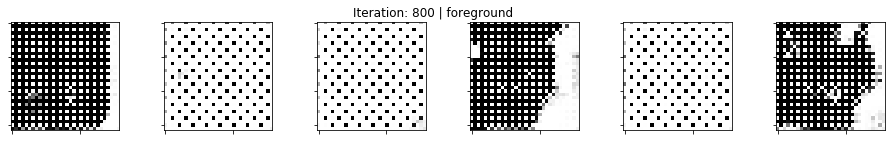

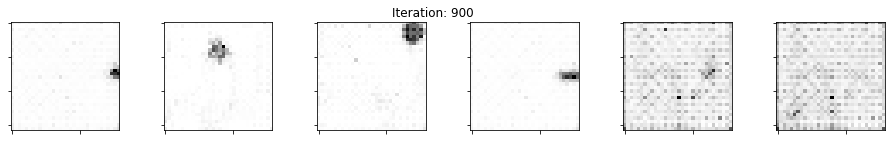

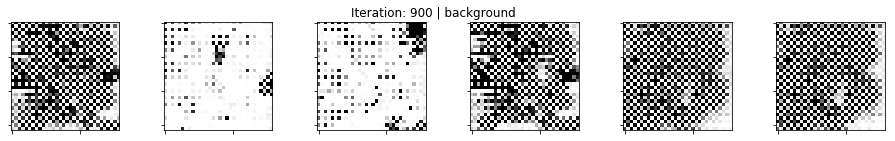

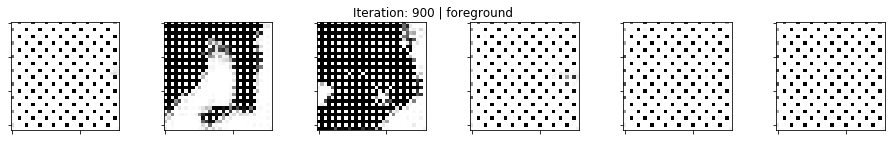

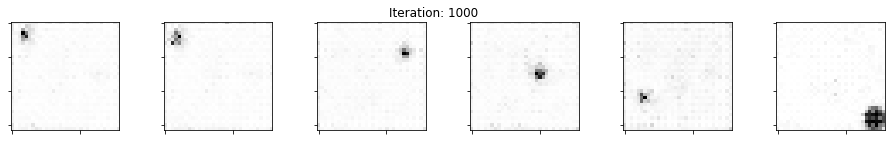

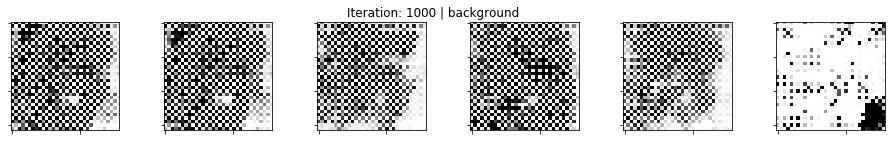

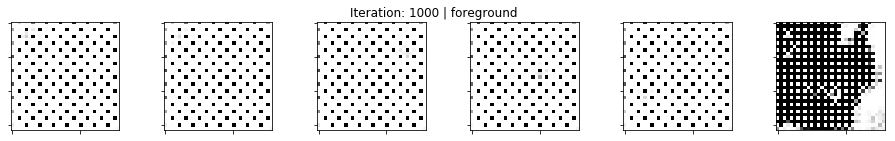

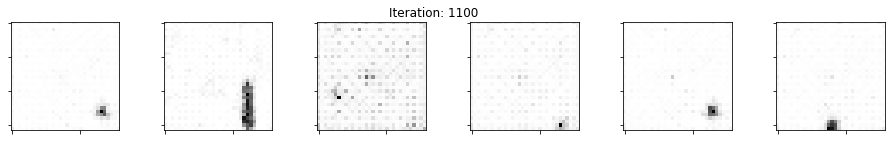

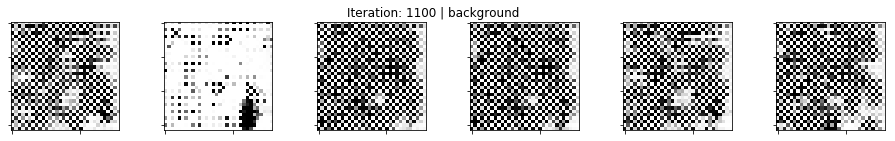

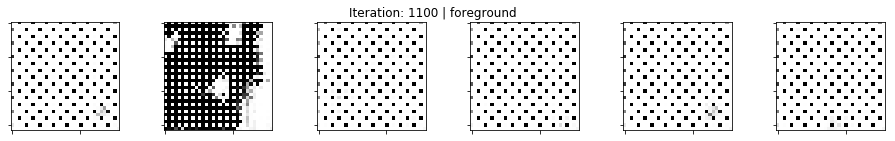

Iteration 1200:  G_loss = 7.458827018737793


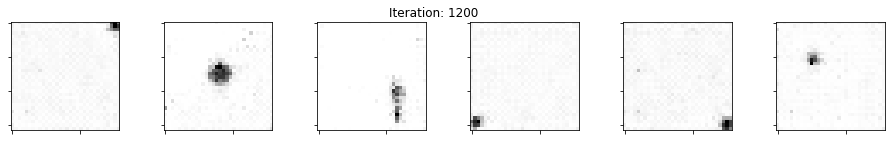

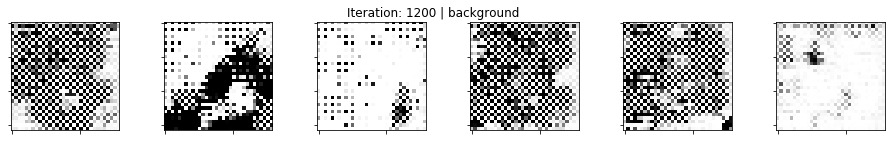

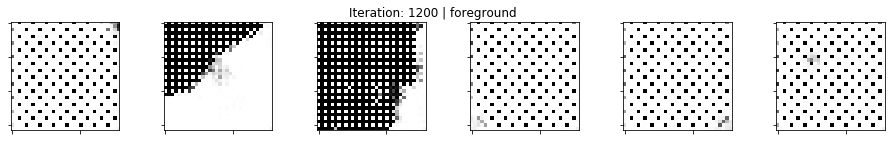

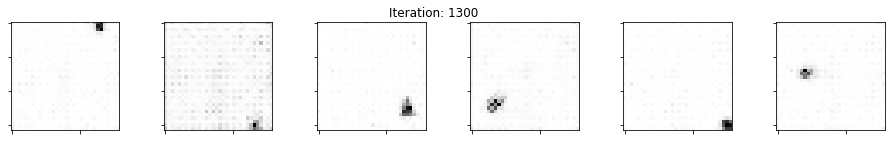

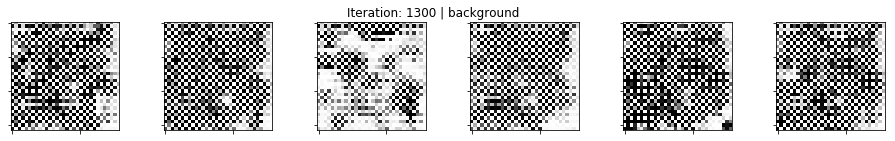

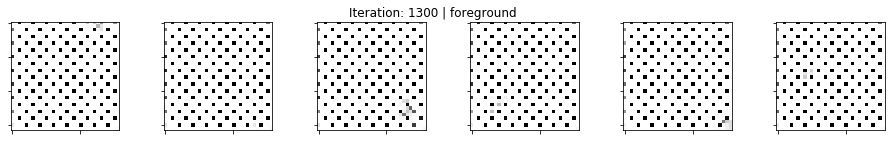

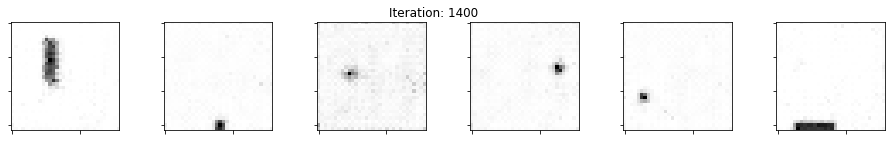

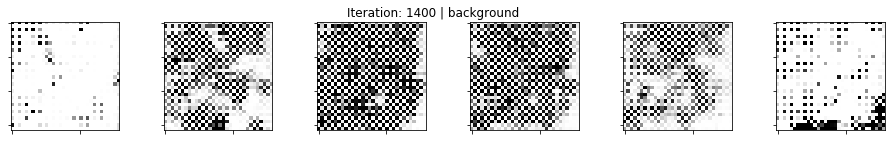

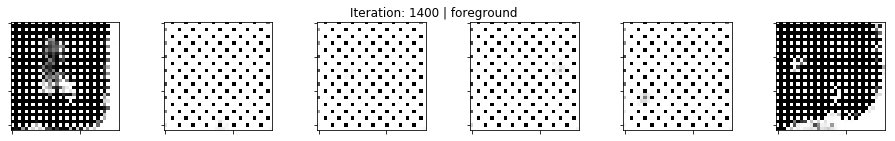

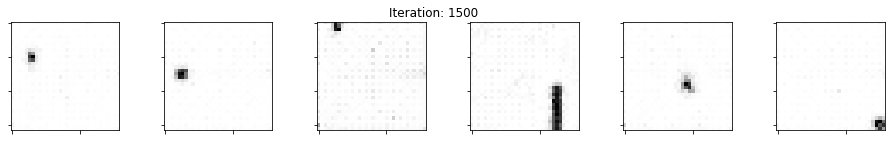

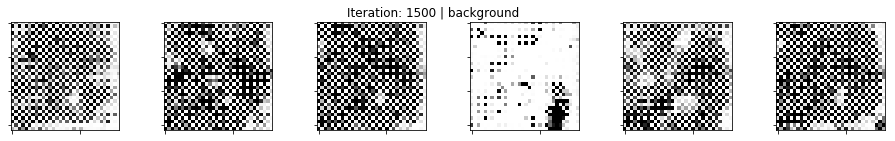

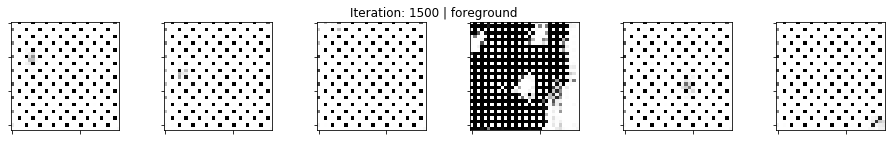

Iteration 1600:  G_loss = 3.121063470840454


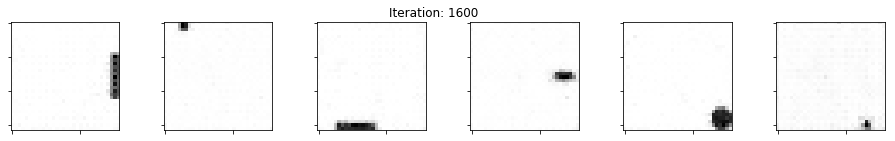

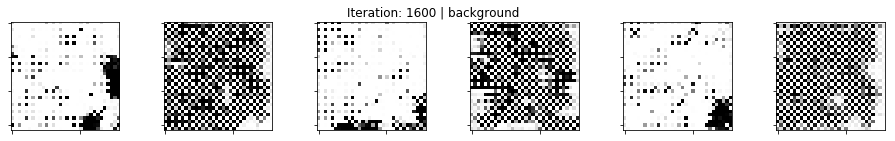

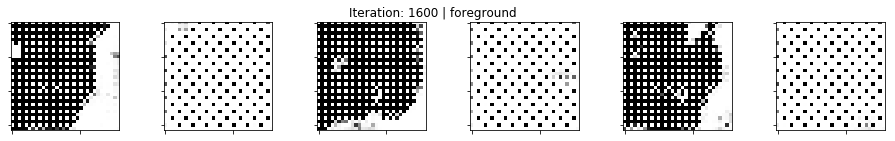

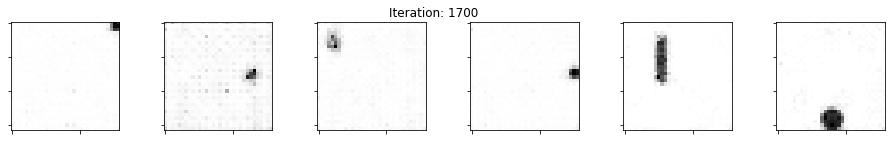

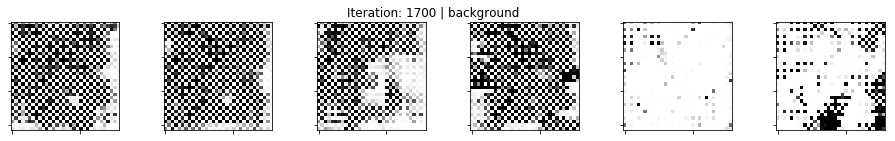

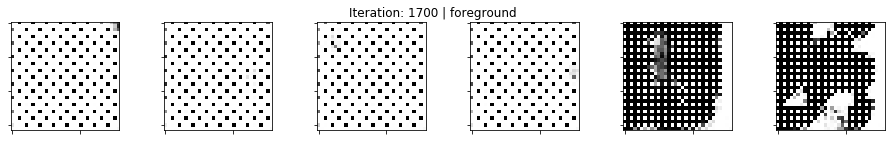

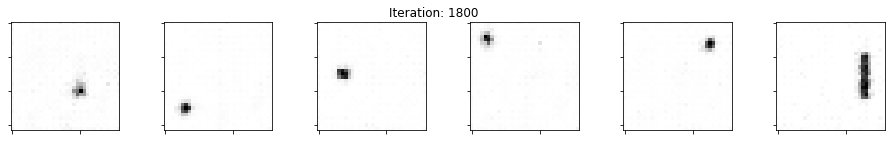

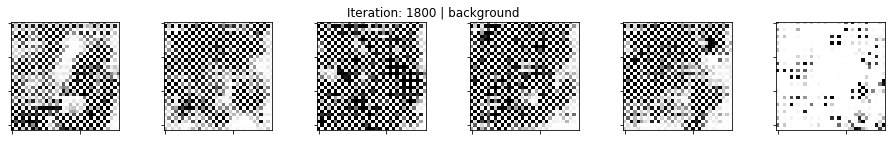

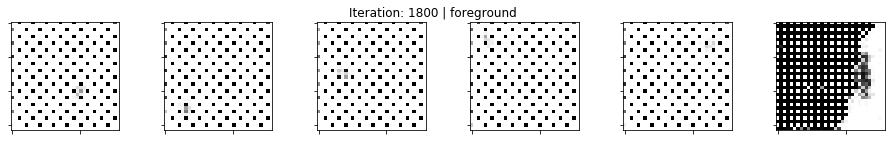

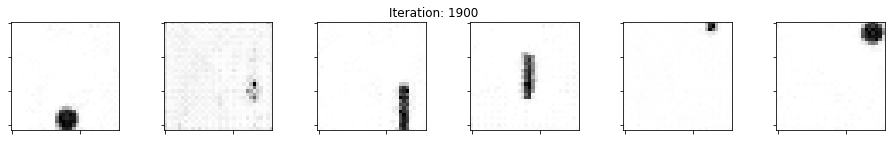

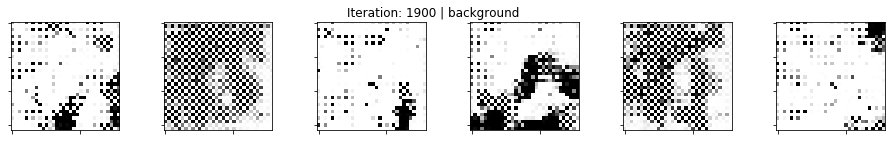

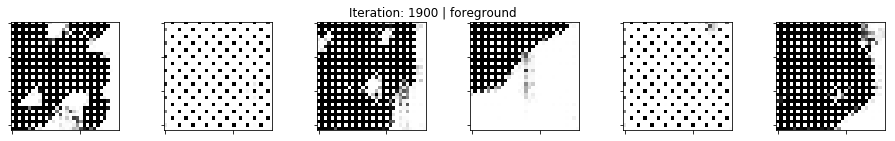

Iteration 2000:  G_loss = 4.681413173675537


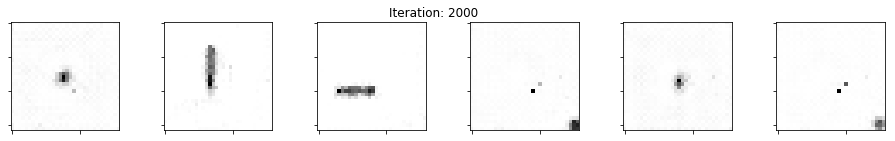

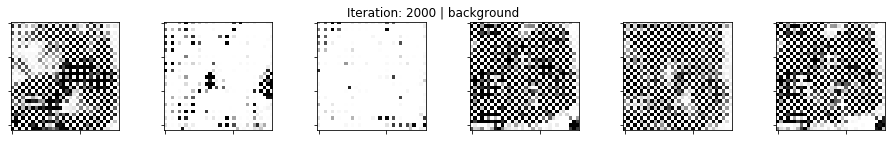

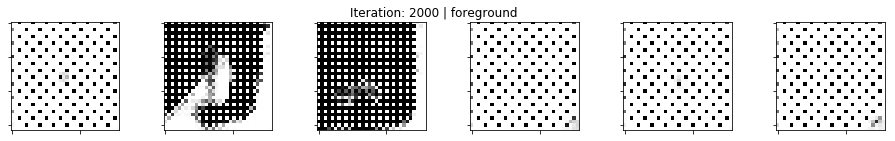

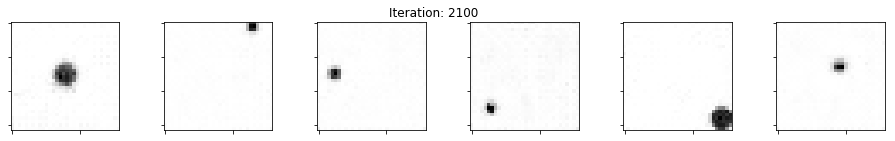

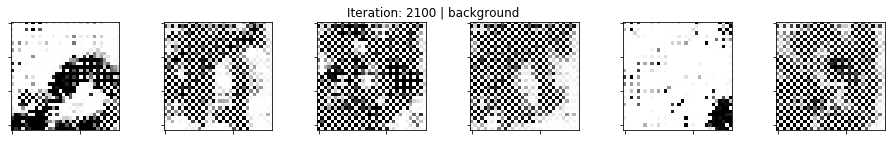

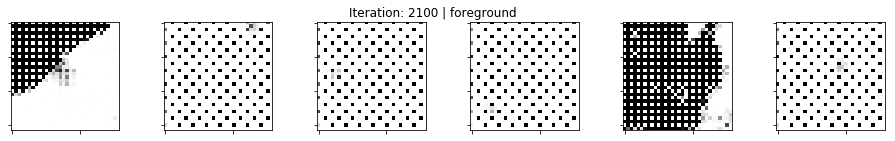

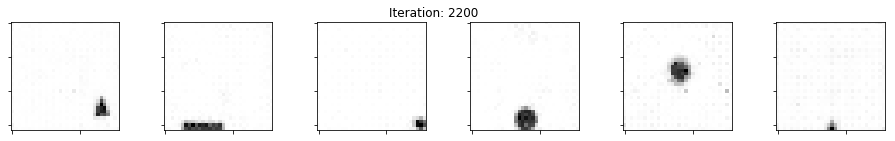

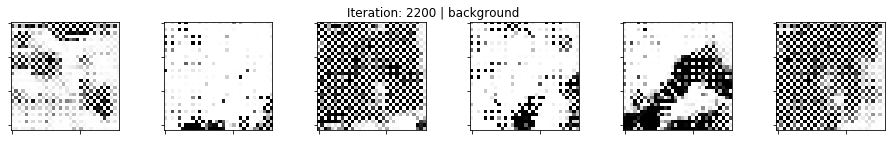

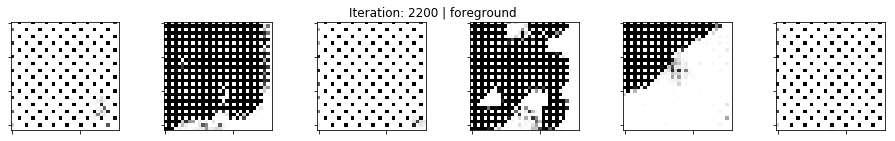

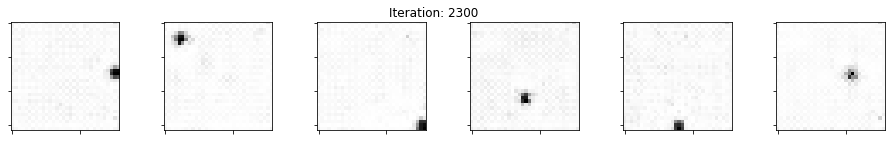

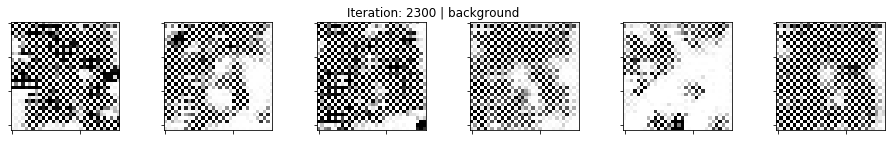

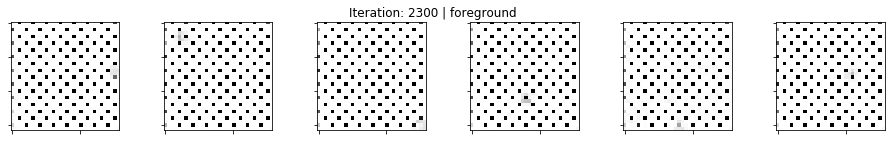

Iteration 2400:  G_loss = 3.786855697631836


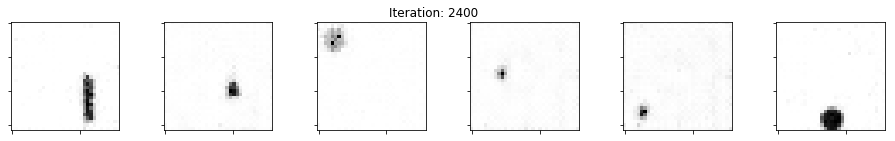

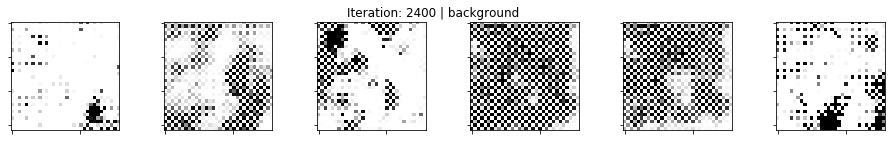

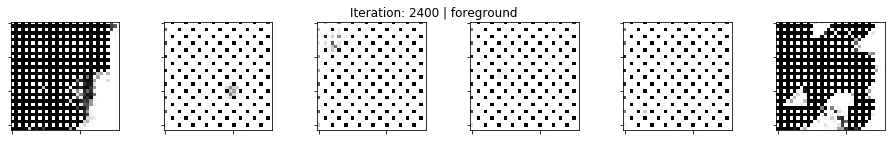

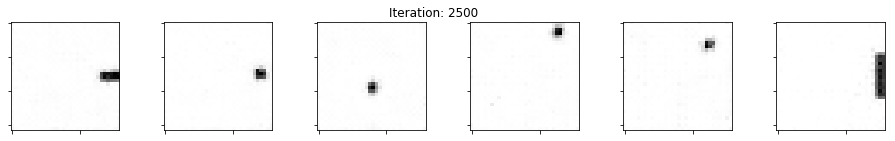

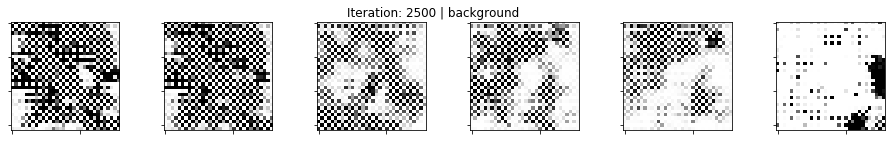

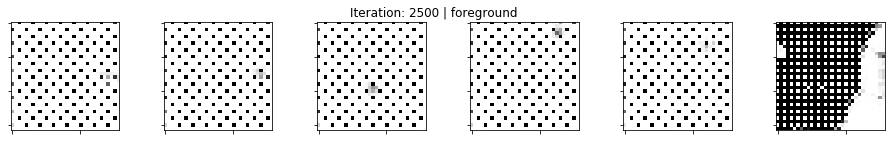

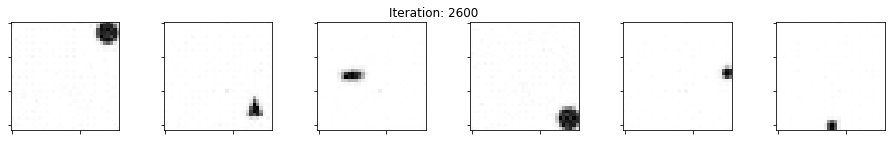

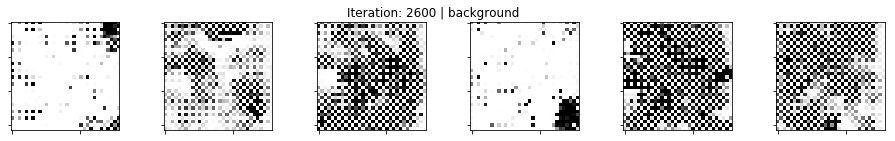

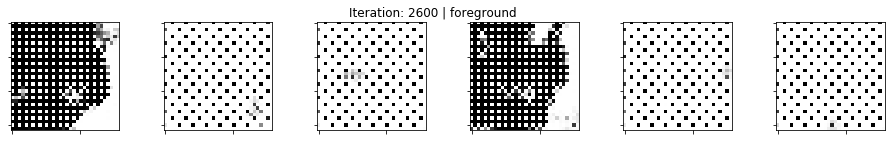

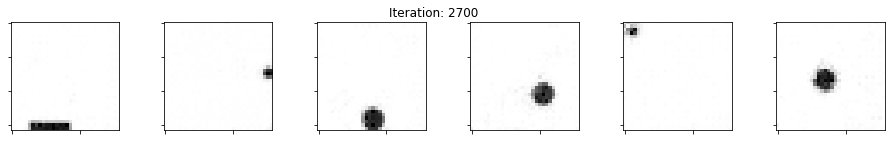

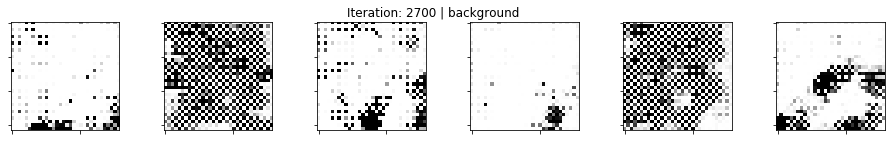

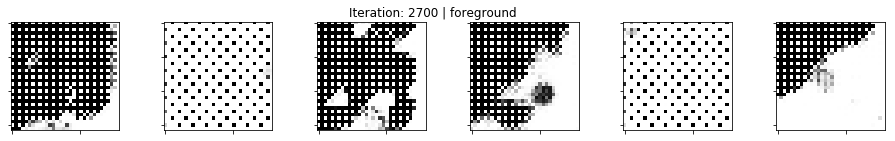

Iteration 2800:  G_loss = 2.0581932067871094


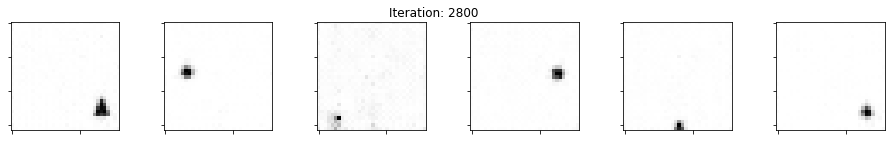

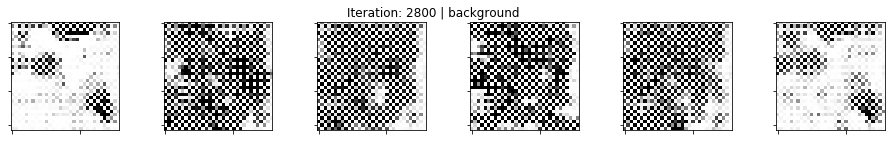

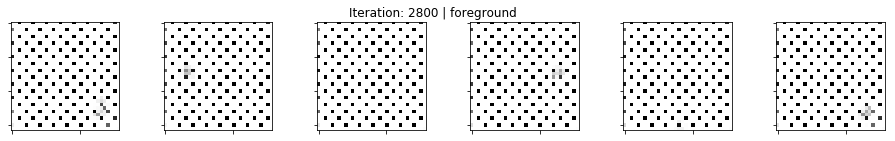

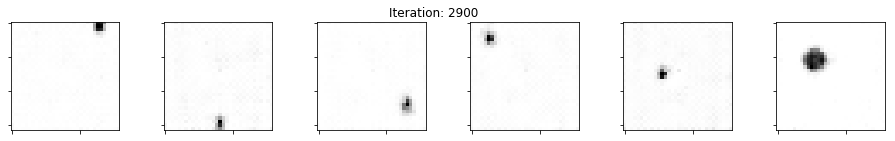

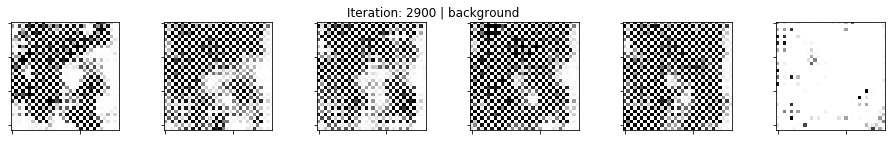

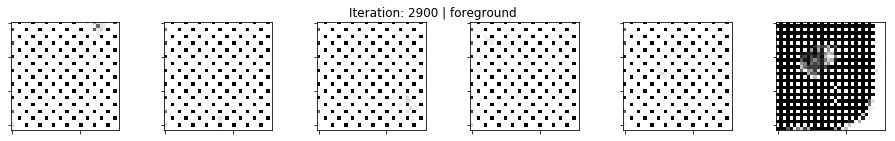

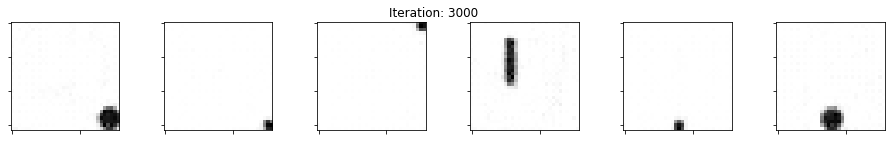

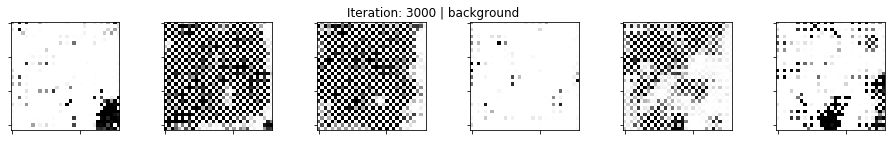

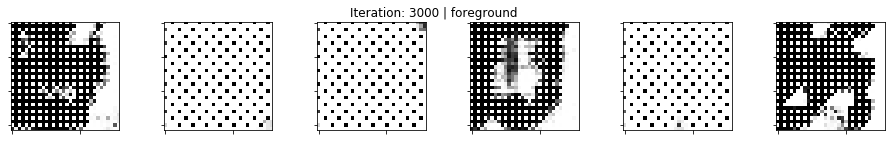

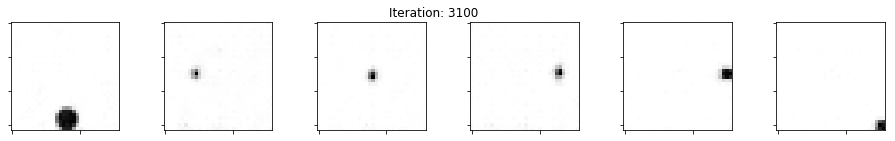

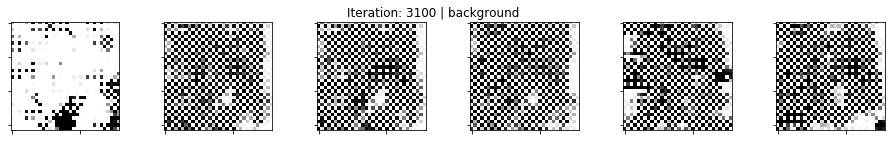

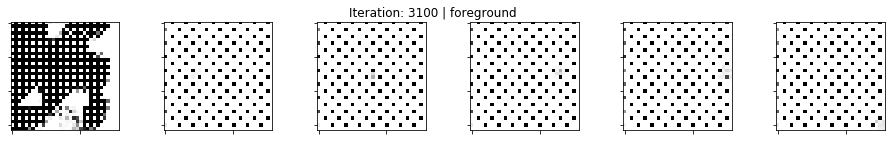

Iteration 3200:  G_loss = 1.6677842140197754


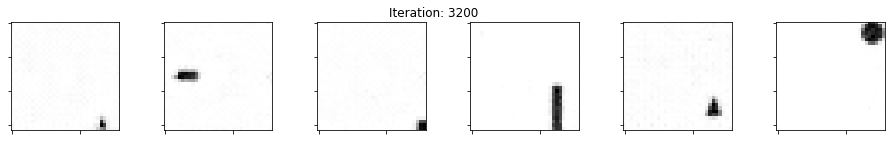

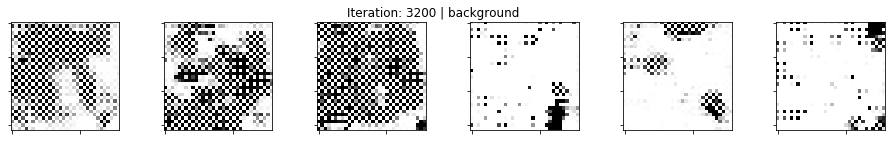

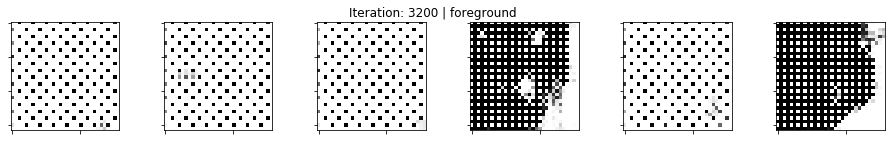

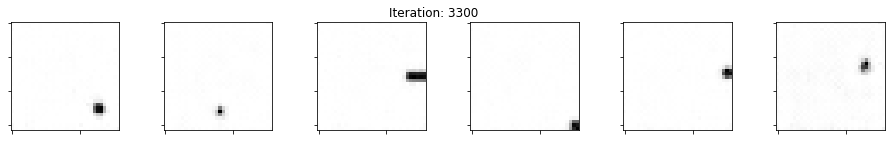

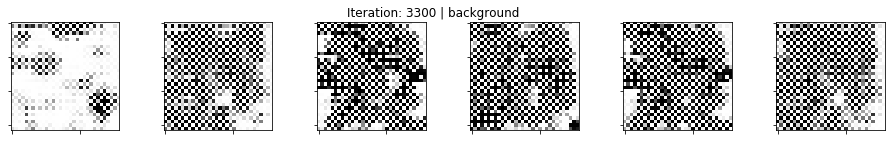

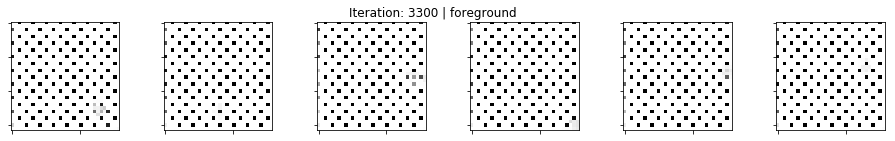

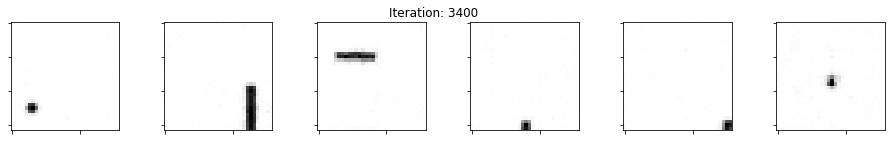

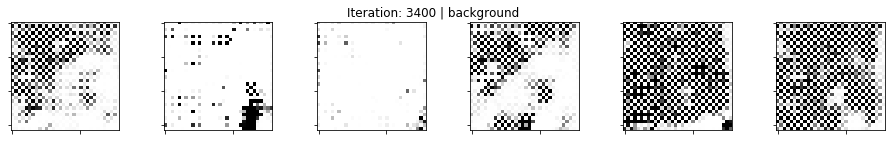

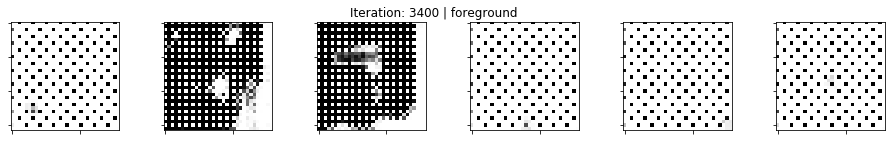

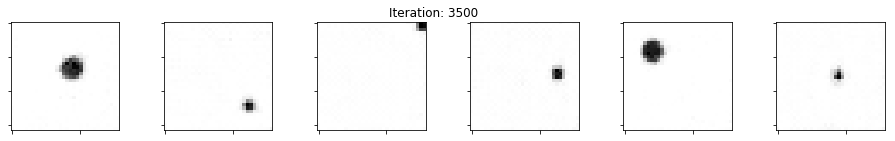

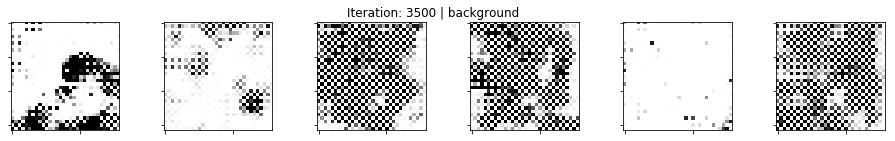

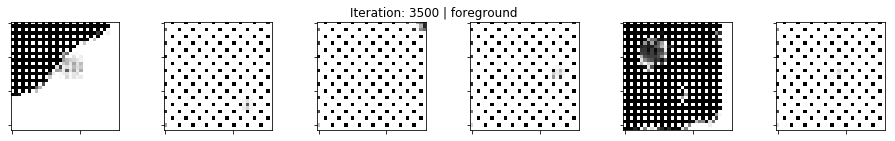

Iteration 3600:  G_loss = 2.3126420974731445


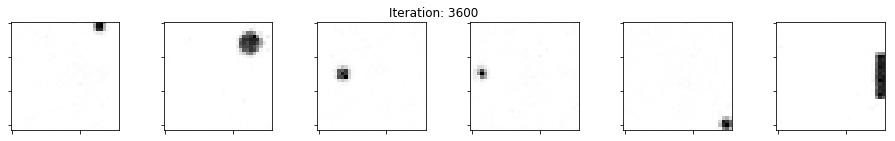

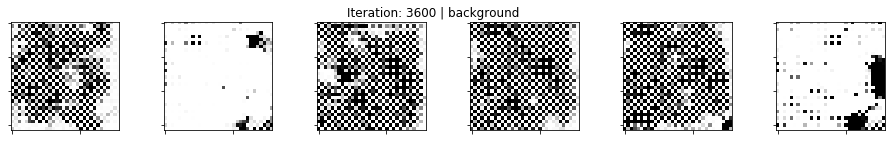

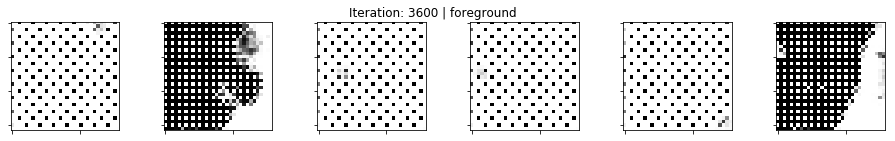

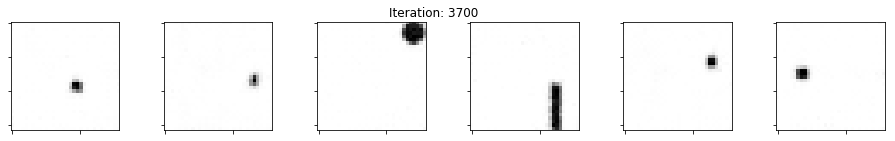

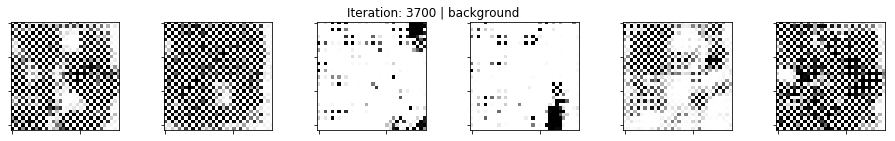

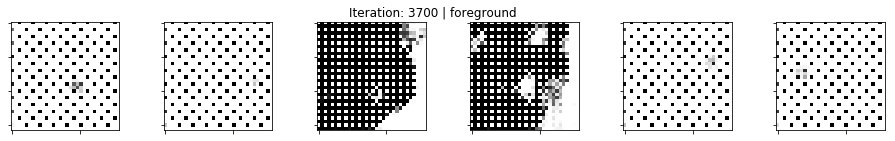

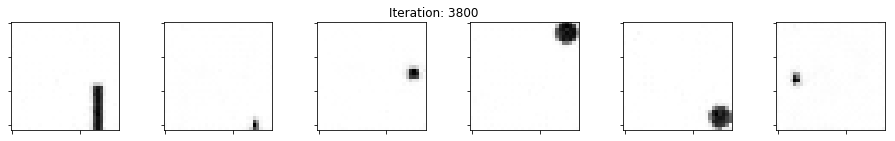

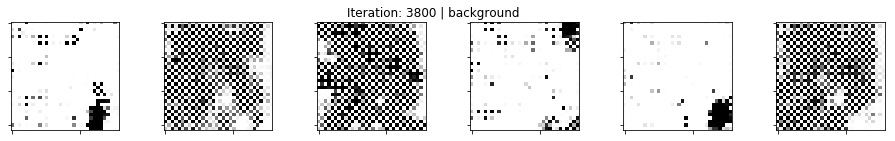

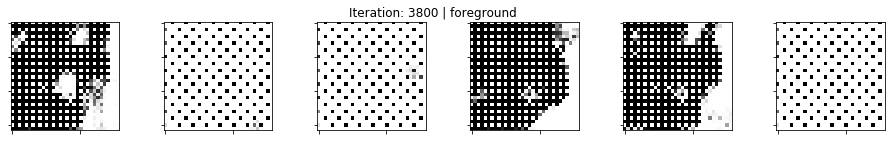

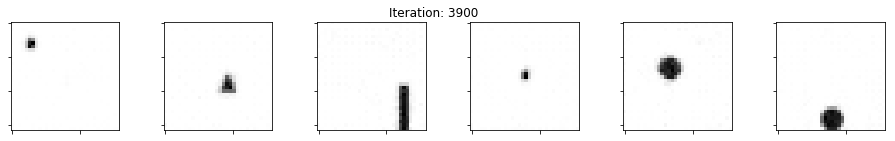

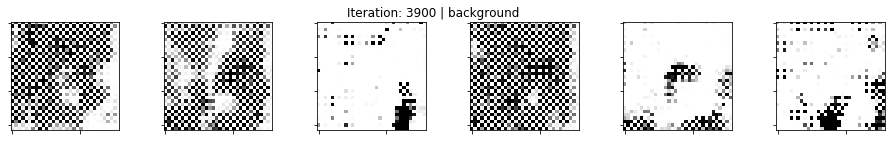

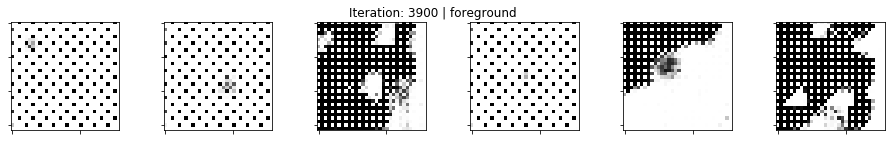

In [74]:
sess = get_session()
sess.run(tf.global_variables_initializer())
g_loss = train(sess, G_train_step, G_loss, batch_size, num_iteration, plot_every = 100)

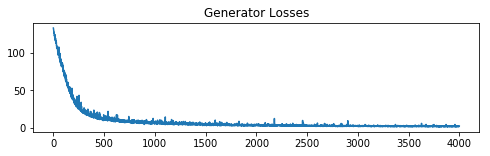

In [75]:
figsize = (8, 2)

plt.figure(figsize=figsize)
plt.plot(g_loss)
plt.title("Generator Losses")
plt.show()

## Validation Loss

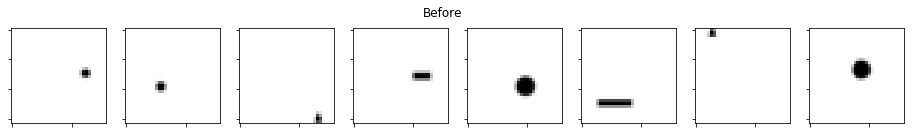

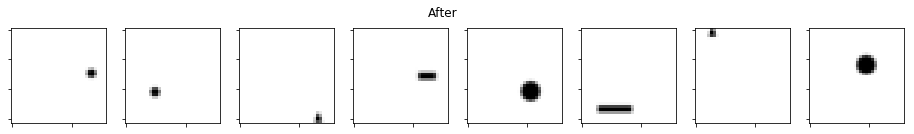

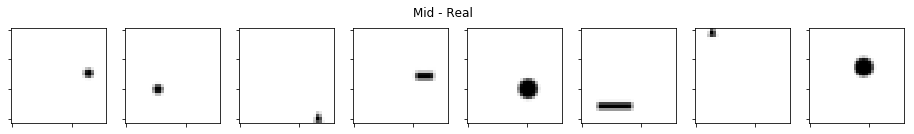

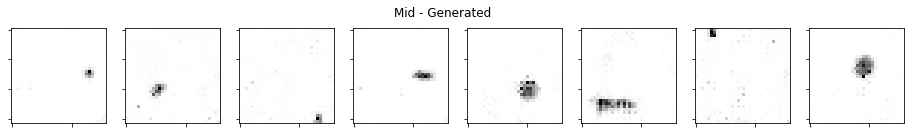

Validation Loss = 26.157535552978516


In [99]:
num = 8
(real_before, real_after), real_mid = sample_dev(num, gap)
dic = {batch_before: real_before, batch_after: real_after, batch_mid: real_mid, is_training: False}
gen_batch, _ = sess.run([G_batch, G_loss], dic)

num_test = 1000
size = (16, 2)
plot_images(real_before, size, "Before")
plot_images(real_after, size, "After")
plot_images(real_mid, size, "Mid - Real")
plot_images(gen_batch, size, "Mid - Generated")

loss = np.mean([get_generattion(test_before, test_after, test_mid)[1] for _ in range(num_test)])
print("Validation Loss = {}".format(loss))

In [77]:
def sample_imgs(imgs, gap = 1, batch_size = 8):
    """
    return: (before, after), mid
    """
    before_indexes = np.random.choice(range(len(imgs) - gap - 1), batch_size, replace=False)
    before_indexes.sort()
    after_indexes = before_indexes + gap + 1
    mid_indexes = (before_indexes + after_indexes)//2
    return (imgs[before_indexes], imgs[after_indexes]), imgs[mid_indexes]

In [78]:
test_imgs = load_imgs("data/moving-box/test/rectangle-32x32.npz")

{'images:': 'rectangle', 'dim': (56, 32, 32)}


## Test a total difference dataset

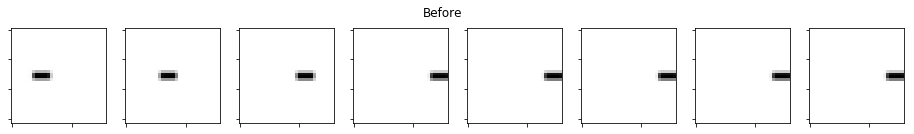

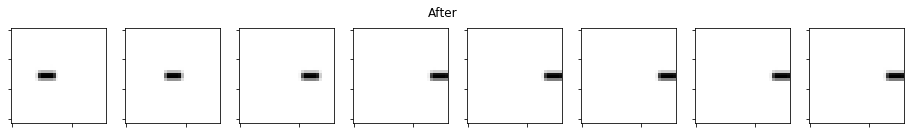

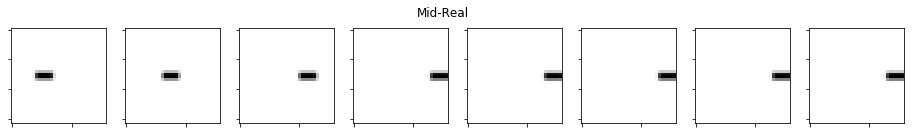

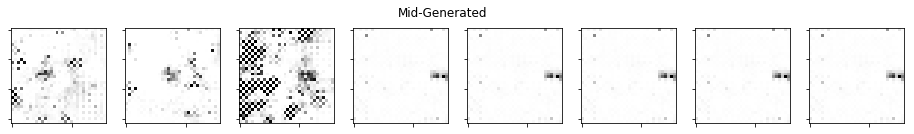

Test Loss = 26.157535552978516


In [98]:
(test_before, test_after), test_mid = sample_imgs(test_imgs, gap = 1)


gen_batch, _ = get_generattion(test_before, test_after, test_mid)

size = (16, 2)
plot_images(test_before, size, "Before")
plot_images(test_after, size, "After")
plot_images(test_mid, size, "Mid-Real")
plot_images(gen_batch, size, "Mid-Generated")


loss = np.mean([get_generattion(test_before, test_after, test_mid)[1] for _ in range(num_test)])
print("Test Loss = {}".format(loss))